## Calibration simulation

This simulates the calibration of an ANSTO two-filter radon detector by injecting radon from a known-activity source into the inlet line, assuming that the ambient radon concentration is zero.

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import generated_functions as gf

In [3]:
# radon decay constant (/s)
lambda_radon = 2.100140526711101e-6

In [4]:
# conversion factors
lpm_to_m3sec = 1/1000/60

*detector-specific parameters, play with these*

In [5]:
# internal flow rate (m3/sec)
Q = 0.0122
# external flow rate (m3/sec)
Q_external = 70.0 * lpm_to_m3sec
# volume of external delay tank (m3)
### - set this to zero if calibration source is injected
###   downstream of external delay tank
V_delay = 0.0
# volume of internal delay volume (m3)
V_tank = 1.5
# additional delay (to account for long inlet line from tower etc.)
t_delay = 0.0

*leave these model parameters fixed, they should apply to most installations*

In [6]:
# screen capture efficiency (0-1)
rs = 0.95
# internal plateout constant (/s)
lamp = 0.005555555555555556
# alpha detection efficiency (0-1)
# --- note: this is set below, based on "total_efficiency"
eff = 1
# recoil probability (0-1)
recoil_prob = 0.025

*parameters describing calibration setup (can be adjusted, but main result below is insensitive to everything here except for the calibration duration)*

In [7]:
# detector cps per ambient Bq/m3 of radon
total_efficiency = 0.15
cal_source_strength = 20e3 # kBq
cal_begin = 3600.0
cal_duration = 3600.0*6
# radon Bq/m3 in calibration gas
Ncal = cal_source_strength / Q_external * lambda_radon

In [8]:
# adjust "eff" so that the total efficiency is equal to that 
# given above
sscps_initial = gf.steady_state_count_rate(rs, recoil_prob, V_tank, Q, lamp, eff)
eff = eff/sscps_initial*total_efficiency

In [9]:
# t - time grid, 1min samples
t = np.arange(0,10*3600,60)

*calculate the number of radon progeny arriving at internal filter (normalised by radon concentration)*

In [10]:
N_af, N_bf = gf.calc_na_nb_factors(Q, lamp, V_tank)

*calculate the total number of counts detected since t = 0*

In [11]:
tc = gf.tc_integral_calibration(Ncal, rs, recoil_prob, V_tank, Q, cal_begin, N_bf, N_af, t, Q_external, eff, cal_duration)

*calculate count rate expected at steady-state*

In [12]:
sscps = gf.steady_state_count_rate(rs, recoil_prob, V_tank, Q, lamp, eff) * Ncal

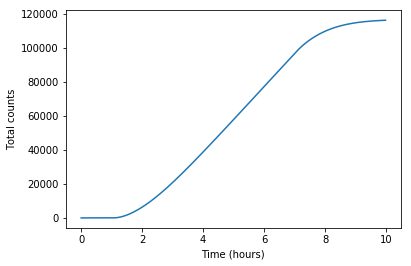

In [13]:
fig, ax = plt.subplots()
ax.plot(t/3600., tc)
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Total counts');

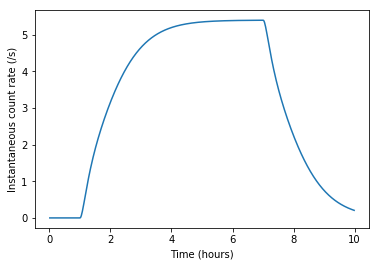

In [14]:
fig, ax = plt.subplots()
ax.plot(t[1:]/3600., np.diff(tc)/np.diff(t))
ax.set_xlabel('Time (hours)')
ax.set_ylabel('Instantaneous count rate (/s)');

In [15]:
df = pd.DataFrame({'total_counts': tc}, index=t.astype(int))

## Report counts/expected counts

This code looks up the total counts recorded by the detector over each hour since the calibration begun, and the compares this to the expected steady-state count rate.

In [16]:
results_list = []

N_cal_hours = int(cal_duration/3600.0)
for ii in range(N_cal_hours):
    t0 = int(ii*3600.0 + cal_begin)
    t1 = int((ii+1)*3600.0 + cal_begin)
    counts_during_interval = (df.loc[t1] - df.loc[t0]).values[0]
    average_count_rate_during_interval = counts_during_interval / 3600.0
    
    dfr = pd.DataFrame({'interval_start_sec': [t0-cal_begin], 
                        'interval_stop_sec': [t1-cal_begin],
                        'counts_during_interval': [counts_during_interval],
                        'steady_state_divided_by_actual_count_rate': 
                        [sscps / average_count_rate_during_interval]})
    results_list.append(dfr)
    
dfr = pd.concat(results_list, ignore_index=True)
dfr

,counts_during_interval,interval_start_sec,interval_stop_sec,steady_state_divided_by_actual_count_rate
0,6332.834318,0.0,3600.0,3.069921
1,14467.222689,3600.0,7200.0,1.343817
2,17935.393399,7200.0,10800.0,1.083963
3,19055.092660,10800.0,14400.0,1.020268
4,19350.486404,14400.0,18000.0,1.004693
5,19420.906923,18000.0,21600.0,1.001050


,total_counts,count_rate,steady_state_divided_by_actual_count_rate
interval_end_time,,,
0,-0.000000,NaN,NaN
3600,6332.834318,1.759121,3.069921
7200,20800.057007,4.018673,1.343817
10800,38735.450407,4.982054,1.083963
14400,57790.543067,5.293081,1.020268
18000,77141.029471,5.375135,1.004693
21600,96561.936394,5.394696,1.001050


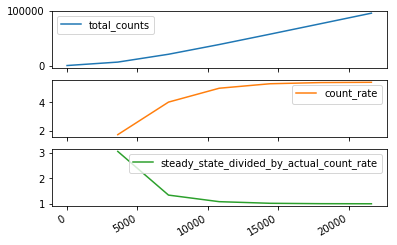

In [17]:
# crosscheck - another way of generating the same table
# subset: the period when radon injection was active
df_cal = df.loc[int(cal_begin):int(cal_begin+cal_duration)]
# index time from stat of cal
df_cal.index -= int(cal_begin)
# take values on the hour
df_cal = df_cal.loc[np.arange(int(cal_duration/3600.0)+1)*3600].copy()
# average count rate per hour
df_cal['count_rate'] = df_cal['total_counts'].diff() / 3600.
df_cal['steady_state_divided_by_actual_count_rate'] = sscps / df_cal['count_rate']
df_cal.steady_state_divided_by_actual_count_rate
df_cal.index.name = 'interval_end_time'
df_cal